In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.utils.data as data

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
train_dataset = datasets.CIFAR10(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = datasets.CIFAR10(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
img, label = train_dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 6


tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.

Label:  ship (8)


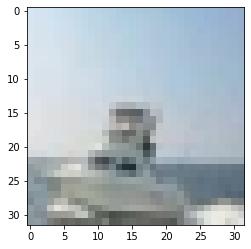

In [ ]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*train_dataset[100])

In [ ]:
val_size = 5000
train_size = len(train_dataset) - val_size

train_dsets, val_dsets = random_split(train_dataset, [train_size, val_size])
len(train_dsets), len(val_dsets)



(45000, 5000)

In [ ]:

# n_iters = 10000
# num_epochs = n_iters / (len(train_dataset) / batch_size)
# num_epochs = int(num_epochs)
batch_size = 128
num_epochs=15
opt_func = torch.optim.Adam
lr = 0.0001
train_loader = data.DataLoader(train_dsets,
                                 shuffle=True,
                                 batch_size=batch_size)

valid_loader = data.DataLoader(val_dsets,
                                 shuffle=False,
                                 batch_size=batch_size)

test_loader = data.DataLoader(test_dataset,
                                shuffle=False,
                                batch_size=batch_size)
print(num_epochs)

15


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

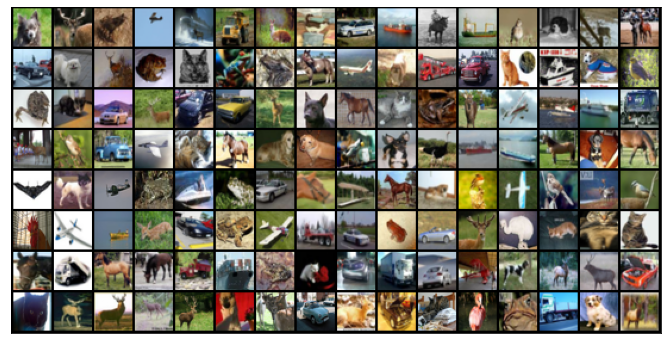

In [ ]:
show_batch(train_loader)

In [ ]:
# Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(1, 1), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(1, 1), # output: 256 x 4 x 4
            nn.Conv2d(256, 512, kernel_size=3,  stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(1, 1), # output: 512 x 4 x 4
            nn.Conv2d(512, 512, kernel_size=3,  stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(1, 1), # output: 512 x 4 x 4

            nn.Flatten(),
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [ ]:
model=model.cuda()

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model.to("cpu")(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0470, -0.0357, -0.0072, -0.0252, -0.0175, -0.0076, -0.0262, -0.0129,
         0.0278, -0.0054], grad_fn=<SelectBackward0>)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(valid_loader, device)
to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
evaluate(model, val_dl)



{'val_loss': 2.30261492729187, 'val_acc': 0.10332031548023224}

In [ ]:
print(opt_func)

<class 'torch.optim.adam.Adam'>


In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.9037, val_loss: 1.6924, val_acc: 0.3590
Epoch [1], train_loss: 1.5497, val_loss: 1.4565, val_acc: 0.4568
Epoch [2], train_loss: 1.3626, val_loss: 1.2714, val_acc: 0.5234
Epoch [3], train_loss: 1.2406, val_loss: 1.2101, val_acc: 0.5574
Epoch [4], train_loss: 1.1469, val_loss: 1.1533, val_acc: 0.5793
Epoch [5], train_loss: 1.0630, val_loss: 1.0561, val_acc: 0.6219
Epoch [6], train_loss: 0.9760, val_loss: 1.0146, val_acc: 0.6361
Epoch [7], train_loss: 0.9136, val_loss: 0.9762, val_acc: 0.6535
Epoch [8], train_loss: 0.8494, val_loss: 0.9922, val_acc: 0.6383
Epoch [9], train_loss: 0.7793, val_loss: 0.9306, val_acc: 0.6719
Epoch [10], train_loss: 0.7131, val_loss: 0.9661, val_acc: 0.6619
Epoch [11], train_loss: 0.6515, val_loss: 0.9438, val_acc: 0.6758
Epoch [12], train_loss: 0.5890, val_loss: 1.0181, val_acc: 0.6652
Epoch [13], train_loss: 0.5331, val_loss: 0.9805, val_acc: 0.6803
Epoch [14], train_loss: 0.4762, val_loss: 1.0318, val_acc: 0.6687


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');



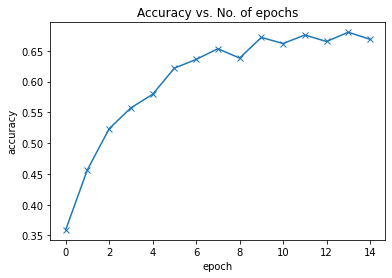

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

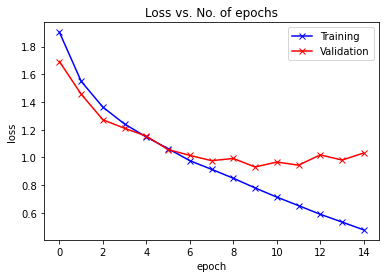

In [ ]:
plot_losses(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]



Label: cat , Predicted: ship


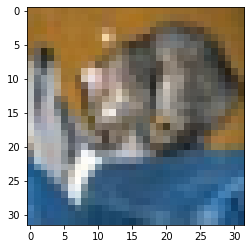

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model.cuda()))



Label: deer , Predicted: deer


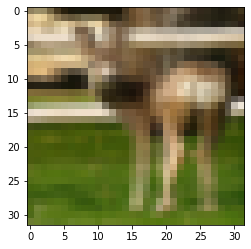

In [ ]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: ship , Predicted: ship


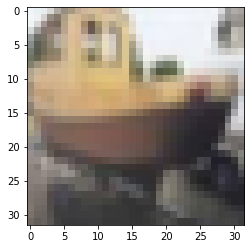

In [ ]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
# import numpy as np

# def plot_images(image_set,label_set,n_images):

#     rows = int(np.sqrt(n_images))
#     cols = int(np.sqrt(n_images))

#     fig = plt.figure(figsize=(20, 10))
#     image, true_label = image_set[1],label_set[1]
#     print(image.shape)
#     output_label=model.to("cpu")(image)
#     _,predicted_label = torch.max(output_label.data, 1)
#     for i in range(rows*cols):
#         ax = fig.add_subplot(rows, cols, i+1)

#         # predicted_label_one=predicted_label[0]
#         # true_label_one=true_label[0]
#         ax.imshow(image[i].permute((1, 2, 0)).cpu().numpy())
#         ax.set_title(f'true label: {classes[true_label[i]]} \n'
#                      f'pred label: {classes[predicted_label[i]]}')
#         ax.axis('off')
#     fig.subplots_adjust(hspace=0.5)

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
print(class_total)
images_set=[]
label_set=[]
with torch.no_grad():
    for data1 in test_loader:
        images, labels = data1
        # print(images.shape,labels)
        outputs = model.to("cpu")(images)
        _,predicted = torch.max(outputs.data, 1)
        # print(predicted)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            if(class_total[label]<5):
              images_set.append(images)
              label_set.append(labels)


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Accuracy of airplane : 75 %
Accuracy of automobile : 82 %
Accuracy of  bird : 63 %
Accuracy of   cat : 50 %
Accuracy of  deer : 37 %
Accuracy of   dog : 45 %
Accuracy of  frog : 72 %
Accuracy of horse : 52 %
Accuracy of  ship : 93 %
Accuracy of truck : 58 %


In [ ]:
image_set=[[],[],[],[],[],[],[],[],[],[]]
for image,label in train_dataset:
  if(len(image_set[label])<5):
    image_set[label].append(image)
    if sum(len(row) for row in image_set) == 50 :
      break
show_dataset=[]
for i in range(0,len(image_set)):
  for j in range(0,len(image_set[i])):
    show_dataset.append([image_set[i][j],i])
# print(len(image_set),len(image_set[0]),len(show_dataset),len(show_dataset[0]))

In [ ]:
import numpy as np

def plot_images(image_set,n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))


    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        true_label=image_set[i][1]
        image=image_set[i][0]
        predicted_label=predict_image(image,model.cuda())
        # print(true_label,predicted_label)
        # imaged = image.view(-1, 32*32*3)
        # imaged = imaged.to(device)

        # y_pred = model(imaged)
        # print(image.shape)
        # # output_label=model.to("cpu")(image)
        # _,predicted_label = torch.max(y_pred.data, 1)
        # # predicted_label_one=predicted_label[0]
        # # true_label_one=true_label[0]
        ax.imshow(image.permute((1, 2, 0)).cpu().numpy())
        ax.set_title(f'true label: {classes[true_label]} \n'
                     f'pred label: {predicted_label}')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

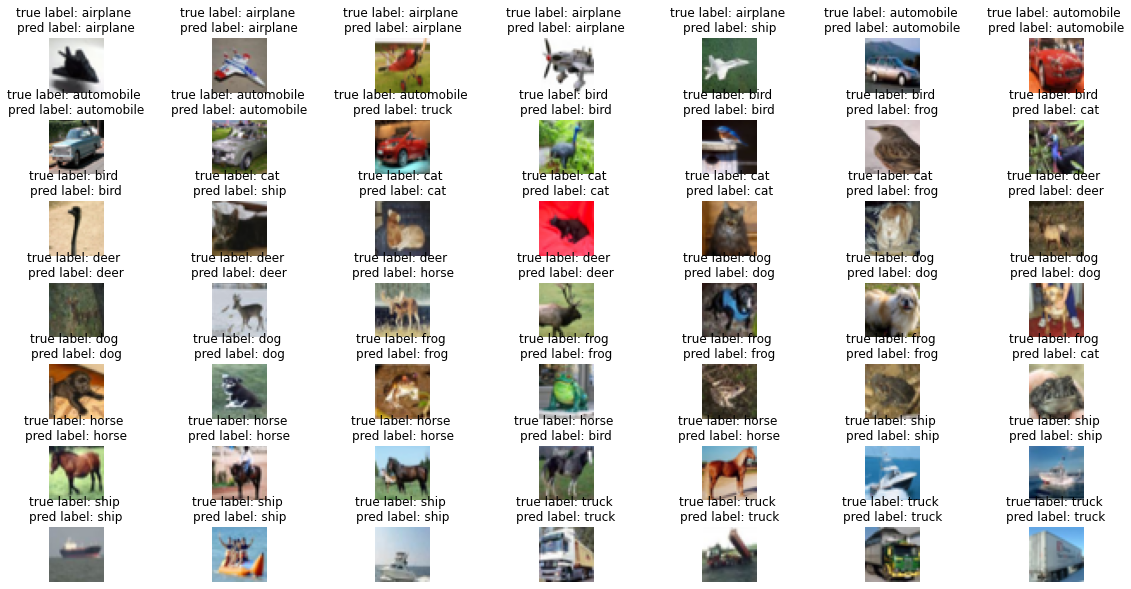

In [ ]:
plot_images(show_dataset,50)

In [ ]:
import matplotlib.pyplot as plt
deer = plt.imread("deer2.jpg") #matplotlib rescales the 8-bit data from each channel to floating-point data between 0.0 and 1.0.
cat = plt.imread("cat2.jpg")
bird = plt.imread("bird2.jpg")
truck = plt.imread("truck2.jpg")
dog = plt.imread("dog2.jpg")
car = plt.imread("car2.jpg")
# plt.imshow(image)
import cv2
cat=cv2.resize(cat, (32,32), interpolation=cv2.INTER_CUBIC)
deer=cv2.resize(deer, (32,32), interpolation=cv2.INTER_CUBIC)
bird=cv2.resize(bird, (32,32), interpolation=cv2.INTER_CUBIC)
truck=cv2.resize(truck, (32,32), interpolation=cv2.INTER_CUBIC)
dog=cv2.resize(dog, (32,32), interpolation=cv2.INTER_CUBIC)
car=cv2.resize(car, (32,32), interpolation=cv2.INTER_CUBIC)

cat=torch.from_numpy(cat)
deer=torch.from_numpy(deer)
bird=torch.from_numpy(bird)
truck=torch.from_numpy(truck)
dog=torch.from_numpy(dog)
car=torch.from_numpy(car)
# label=4'airplane',
# [ 'automobile',
#  'bird',
#  'cat',
#  'deer',
#  'dog',
#  'frog',
#  'horse',
#  'ship',
#  'truck']
random_image_set=[[deer.to(torch.float32).permute(2, 1,0),4],[cat.to(torch.float32).permute(2, 1,0),3],[dog.to(torch.float32).permute(2, 1,0),5],[car.to(torch.float32).permute(2, 1,0),1],[truck.to(torch.float32).permute(2, 1,0),9],[bird.to(torch.float32).permute(2, 1,0),2]]

# img==img.to(torch.float32)
# plt.imshow(img)
# print(img.permute(2, 1, 0).shape,type(img),img.to(torch.float32))
# print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img.permute(2, 0,1).to(torch.float32), model))
plot_images(random_image_set,5)

FileNotFoundError: ignored

In [ ]:
test_loader = DeviceDataLoader(test_loader, device)
model=model.cuda()
result = evaluate(model, test_loader)
result

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn-vgg11-maxpool2*2.pth')



In [ ]:
model2 = to_device(Cifar10CnnModel(), device)

In [ ]:
model2.load_state_dict(torch.load('cifar10-cnn-vgg11-maxpool2*2.pth'))

In [ ]:


evaluate(model2, test_loader)

